# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.ReLU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Dropout(p = 0.01),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size)
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [8]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/800, Iteration 1/12, Loss: 0.9626
Epoch 1/800, Iteration 2/12, Loss: 0.8316
Epoch 1/800, Iteration 3/12, Loss: 0.9198
Epoch 1/800, Iteration 4/12, Loss: 0.9310
Epoch 1/800, Iteration 5/12, Loss: 0.8632
Epoch 1/800, Iteration 6/12, Loss: 0.6050
Epoch 1/800, Iteration 7/12, Loss: 0.7615
Epoch 1/800, Iteration 8/12, Loss: 0.7742
Epoch 1/800, Iteration 9/12, Loss: 0.7172
Epoch 1/800, Iteration 10/12, Loss: 0.5575
Epoch 1/800, Iteration 11/12, Loss: 0.8109
Epoch 1/800, Iteration 12/12, Loss: 0.7373
Epoch 1/800, Iteration 13/12, Loss: 0.5638
Train Error: 
 Accuracy: 45.38%, Avg loss: 0.542381, MRE: 0.512800, MAE: 0.080326 

Test Error: 
 Accuracy: 48.5%, Avg loss: 0.490218, MRE: 0.410703, MAE: 0.070456 

Epoch 2/800, Iteration 1/12, Loss: 0.6236
Epoch 2/800, Iteration 2/12, Loss: 0.5415
Epoch 2/800, Iteration 3/12, Loss: 0.5185
Epoch 2/800, Iteration 4/12, Loss: 0.4486
Epoch 2/800, Iteration 5/12, Loss: 0.3836
Epoch 2/800, Iteration 6/12, Loss: 0.3088
Epoch 2/800, Iteration 7/12, Los

Train Error: 
 Accuracy: 81.12%, Avg loss: 0.034556, MRE: 0.073050, MAE: 0.015274 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.026039, MRE: 0.065776, MAE: 0.014032 

Epoch 13/800, Iteration 1/12, Loss: 0.0300
Epoch 13/800, Iteration 2/12, Loss: 0.0250
Epoch 13/800, Iteration 3/12, Loss: 0.0294
Epoch 13/800, Iteration 4/12, Loss: 0.0269
Epoch 13/800, Iteration 5/12, Loss: 0.0373
Epoch 13/800, Iteration 6/12, Loss: 0.0522
Epoch 13/800, Iteration 7/12, Loss: 0.0160
Epoch 13/800, Iteration 8/12, Loss: 0.0324
Epoch 13/800, Iteration 9/12, Loss: 0.0391
Epoch 13/800, Iteration 10/12, Loss: 0.0450
Epoch 13/800, Iteration 11/12, Loss: 0.0215
Epoch 13/800, Iteration 12/12, Loss: 0.0487
Epoch 13/800, Iteration 13/12, Loss: 0.0260
Train Error: 
 Accuracy: 84.5%, Avg loss: 0.033739, MRE: 0.071727, MAE: 0.014667 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.025546, MRE: 0.063701, MAE: 0.013932 

Epoch 14/800, Iteration 1/12, Loss: 0.0268
Epoch 14/800, Iteration 2/12, Loss: 0.0127
Epoch 14/800, Iterat

Train Error: 
 Accuracy: 89.88%, Avg loss: 0.020983, MRE: 0.058803, MAE: 0.011216 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.019826, MRE: 0.052241, MAE: 0.012029 

Epoch 25/800, Iteration 1/12, Loss: 0.0178
Epoch 25/800, Iteration 2/12, Loss: 0.0201
Epoch 25/800, Iteration 3/12, Loss: 0.0092
Epoch 25/800, Iteration 4/12, Loss: 0.0402
Epoch 25/800, Iteration 5/12, Loss: 0.0181
Epoch 25/800, Iteration 6/12, Loss: 0.0233
Epoch 25/800, Iteration 7/12, Loss: 0.0372
Epoch 25/800, Iteration 8/12, Loss: 0.0135
Epoch 25/800, Iteration 9/12, Loss: 0.0253
Epoch 25/800, Iteration 10/12, Loss: 0.0150
Epoch 25/800, Iteration 11/12, Loss: 0.0155
Epoch 25/800, Iteration 12/12, Loss: 0.0235
Epoch 25/800, Iteration 13/12, Loss: 0.0280
Train Error: 
 Accuracy: 90.75%, Avg loss: 0.020383, MRE: 0.058948, MAE: 0.011113 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.020165, MRE: 0.052673, MAE: 0.012034 

Epoch 26/800, Iteration 1/12, Loss: 0.0351
Epoch 26/800, Iteration 2/12, Loss: 0.0188
Epoch 26/800, Itera

Train Error: 
 Accuracy: 91.38%, Avg loss: 0.016552, MRE: 0.055347, MAE: 0.009738 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.015956, MRE: 0.047861, MAE: 0.010745 

Epoch 37/800, Iteration 1/12, Loss: 0.0241
Epoch 37/800, Iteration 2/12, Loss: 0.0125
Epoch 37/800, Iteration 3/12, Loss: 0.0315
Epoch 37/800, Iteration 4/12, Loss: 0.0159
Epoch 37/800, Iteration 5/12, Loss: 0.0155
Epoch 37/800, Iteration 6/12, Loss: 0.0181
Epoch 37/800, Iteration 7/12, Loss: 0.0258
Epoch 37/800, Iteration 8/12, Loss: 0.0255
Epoch 37/800, Iteration 9/12, Loss: 0.0075
Epoch 37/800, Iteration 10/12, Loss: 0.0136
Epoch 37/800, Iteration 11/12, Loss: 0.0070
Epoch 37/800, Iteration 12/12, Loss: 0.0168
Epoch 37/800, Iteration 13/12, Loss: 0.0098
Train Error: 
 Accuracy: 87.75%, Avg loss: 0.016248, MRE: 0.053765, MAE: 0.009568 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.013592, MRE: 0.046650, MAE: 0.010167 

Epoch 38/800, Iteration 1/12, Loss: 0.0188
Epoch 38/800, Iteration 2/12, Loss: 0.0182
Epoch 38/800, Itera

Train Error: 
 Accuracy: 92.12%, Avg loss: 0.013768, MRE: 0.049703, MAE: 0.008668 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.012745, MRE: 0.043126, MAE: 0.009486 

Epoch 49/800, Iteration 1/12, Loss: 0.0378
Epoch 49/800, Iteration 2/12, Loss: 0.0074
Epoch 49/800, Iteration 3/12, Loss: 0.0131
Epoch 49/800, Iteration 4/12, Loss: 0.0126
Epoch 49/800, Iteration 5/12, Loss: 0.0116
Epoch 49/800, Iteration 6/12, Loss: 0.0153
Epoch 49/800, Iteration 7/12, Loss: 0.0175
Epoch 49/800, Iteration 8/12, Loss: 0.0168
Epoch 49/800, Iteration 9/12, Loss: 0.0104
Epoch 49/800, Iteration 10/12, Loss: 0.0100
Epoch 49/800, Iteration 11/12, Loss: 0.0187
Epoch 49/800, Iteration 12/12, Loss: 0.0060
Epoch 49/800, Iteration 13/12, Loss: 0.0193
Train Error: 
 Accuracy: 88.62%, Avg loss: 0.015681, MRE: 0.050797, MAE: 0.008867 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.010879, MRE: 0.041892, MAE: 0.008957 

Epoch 50/800, Iteration 1/12, Loss: 0.0135
Epoch 50/800, Iteration 2/12, Loss: 0.0111
Epoch 50/800, Itera

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.012199, MRE: 0.046800, MAE: 0.008001 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.011096, MRE: 0.039618, MAE: 0.008736 

Epoch 61/800, Iteration 1/12, Loss: 0.0041
Epoch 61/800, Iteration 2/12, Loss: 0.0131
Epoch 61/800, Iteration 3/12, Loss: 0.0092
Epoch 61/800, Iteration 4/12, Loss: 0.0104
Epoch 61/800, Iteration 5/12, Loss: 0.0106
Epoch 61/800, Iteration 6/12, Loss: 0.0154
Epoch 61/800, Iteration 7/12, Loss: 0.0105
Epoch 61/800, Iteration 8/12, Loss: 0.0247
Epoch 61/800, Iteration 9/12, Loss: 0.0092
Epoch 61/800, Iteration 10/12, Loss: 0.0123
Epoch 61/800, Iteration 11/12, Loss: 0.0160
Epoch 61/800, Iteration 12/12, Loss: 0.0232
Epoch 61/800, Iteration 13/12, Loss: 0.0155
Train Error: 
 Accuracy: 91.38%, Avg loss: 0.012014, MRE: 0.045317, MAE: 0.007909 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.010178, MRE: 0.038767, MAE: 0.008363 

Epoch 62/800, Iteration 1/12, Loss: 0.0177
Epoch 62/800, Iteration 2/12, Loss: 0.0133
Epoch 62/800, Iterat

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.011021, MRE: 0.044157, MAE: 0.007492 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.010094, MRE: 0.037374, MAE: 0.008090 

Epoch 73/800, Iteration 1/12, Loss: 0.0127
Epoch 73/800, Iteration 2/12, Loss: 0.0102
Epoch 73/800, Iteration 3/12, Loss: 0.0048
Epoch 73/800, Iteration 4/12, Loss: 0.0081
Epoch 73/800, Iteration 5/12, Loss: 0.0229
Epoch 73/800, Iteration 6/12, Loss: 0.0114
Epoch 73/800, Iteration 7/12, Loss: 0.0142
Epoch 73/800, Iteration 8/12, Loss: 0.0134
Epoch 73/800, Iteration 9/12, Loss: 0.0112
Epoch 73/800, Iteration 10/12, Loss: 0.0202
Epoch 73/800, Iteration 11/12, Loss: 0.0159
Epoch 73/800, Iteration 12/12, Loss: 0.0082
Epoch 73/800, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 92.75%, Avg loss: 0.011766, MRE: 0.043447, MAE: 0.007447 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.009168, MRE: 0.035707, MAE: 0.007769 

Epoch 74/800, Iteration 1/12, Loss: 0.0151
Epoch 74/800, Iteration 2/12, Loss: 0.0097
Epoch 74/800, Itera

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.009808, MRE: 0.040481, MAE: 0.006981 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.008907, MRE: 0.034437, MAE: 0.007514 

Epoch 85/800, Iteration 1/12, Loss: 0.0083
Epoch 85/800, Iteration 2/12, Loss: 0.0162
Epoch 85/800, Iteration 3/12, Loss: 0.0072
Epoch 85/800, Iteration 4/12, Loss: 0.0065
Epoch 85/800, Iteration 5/12, Loss: 0.0053
Epoch 85/800, Iteration 6/12, Loss: 0.0070
Epoch 85/800, Iteration 7/12, Loss: 0.0213
Epoch 85/800, Iteration 8/12, Loss: 0.0135
Epoch 85/800, Iteration 9/12, Loss: 0.0086
Epoch 85/800, Iteration 10/12, Loss: 0.0059
Epoch 85/800, Iteration 11/12, Loss: 0.0225
Epoch 85/800, Iteration 12/12, Loss: 0.0102
Epoch 85/800, Iteration 13/12, Loss: 0.0130
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.010744, MRE: 0.041552, MAE: 0.007145 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.009303, MRE: 0.035014, MAE: 0.007645 

Epoch 86/800, Iteration 1/12, Loss: 0.0144
Epoch 86/800, Iteration 2/12, Loss: 0.0041
Epoch 86/800, Itera

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.008994, MRE: 0.037279, MAE: 0.006642 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.008065, MRE: 0.032448, MAE: 0.007159 

Epoch 97/800, Iteration 1/12, Loss: 0.0073
Epoch 97/800, Iteration 2/12, Loss: 0.0115
Epoch 97/800, Iteration 3/12, Loss: 0.0126
Epoch 97/800, Iteration 4/12, Loss: 0.0136
Epoch 97/800, Iteration 5/12, Loss: 0.0096
Epoch 97/800, Iteration 6/12, Loss: 0.0086
Epoch 97/800, Iteration 7/12, Loss: 0.0112
Epoch 97/800, Iteration 8/12, Loss: 0.0083
Epoch 97/800, Iteration 9/12, Loss: 0.0115
Epoch 97/800, Iteration 10/12, Loss: 0.0061
Epoch 97/800, Iteration 11/12, Loss: 0.0191
Epoch 97/800, Iteration 12/12, Loss: 0.0094
Epoch 97/800, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 94.38%, Avg loss: 0.009102, MRE: 0.038044, MAE: 0.006637 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.008154, MRE: 0.032353, MAE: 0.007122 

Epoch 98/800, Iteration 1/12, Loss: 0.0062
Epoch 98/800, Iteration 2/12, Loss: 0.0098
Epoch 98/800, Itera

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.008754, MRE: 0.036602, MAE: 0.006409 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.007054, MRE: 0.030882, MAE: 0.006721 

Epoch 109/800, Iteration 1/12, Loss: 0.0072
Epoch 109/800, Iteration 2/12, Loss: 0.0078
Epoch 109/800, Iteration 3/12, Loss: 0.0038
Epoch 109/800, Iteration 4/12, Loss: 0.0039
Epoch 109/800, Iteration 5/12, Loss: 0.0180
Epoch 109/800, Iteration 6/12, Loss: 0.0204
Epoch 109/800, Iteration 7/12, Loss: 0.0057
Epoch 109/800, Iteration 8/12, Loss: 0.0210
Epoch 109/800, Iteration 9/12, Loss: 0.0049
Epoch 109/800, Iteration 10/12, Loss: 0.0092
Epoch 109/800, Iteration 11/12, Loss: 0.0122
Epoch 109/800, Iteration 12/12, Loss: 0.0051
Epoch 109/800, Iteration 13/12, Loss: 0.0086
Train Error: 
 Accuracy: 93.88%, Avg loss: 0.008162, MRE: 0.035814, MAE: 0.006259 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.007281, MRE: 0.031168, MAE: 0.006784 

Epoch 110/800, Iteration 1/12, Loss: 0.0147
Epoch 110/800, Iteration 2/12, Loss: 0.0050
Epoc

Train Error: 
 Accuracy: 94.88%, Avg loss: 0.007870, MRE: 0.034977, MAE: 0.006197 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007543, MRE: 0.031086, MAE: 0.006758 

Epoch 121/800, Iteration 1/12, Loss: 0.0050
Epoch 121/800, Iteration 2/12, Loss: 0.0068
Epoch 121/800, Iteration 3/12, Loss: 0.0042
Epoch 121/800, Iteration 4/12, Loss: 0.0042
Epoch 121/800, Iteration 5/12, Loss: 0.0180
Epoch 121/800, Iteration 6/12, Loss: 0.0223
Epoch 121/800, Iteration 7/12, Loss: 0.0139
Epoch 121/800, Iteration 8/12, Loss: 0.0079
Epoch 121/800, Iteration 9/12, Loss: 0.0034
Epoch 121/800, Iteration 10/12, Loss: 0.0073
Epoch 121/800, Iteration 11/12, Loss: 0.0068
Epoch 121/800, Iteration 12/12, Loss: 0.0079
Epoch 121/800, Iteration 13/12, Loss: 0.0107
Train Error: 
 Accuracy: 93.0%, Avg loss: 0.008114, MRE: 0.035201, MAE: 0.006221 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006212, MRE: 0.029997, MAE: 0.006383 

Epoch 122/800, Iteration 1/12, Loss: 0.0071
Epoch 122/800, Iteration 2/12, Loss: 0.0166
Epoch

Epoch 132/800, Iteration 9/12, Loss: 0.0043
Epoch 132/800, Iteration 10/12, Loss: 0.0169
Epoch 132/800, Iteration 11/12, Loss: 0.0048
Epoch 132/800, Iteration 12/12, Loss: 0.0052
Epoch 132/800, Iteration 13/12, Loss: 0.0077
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.007453, MRE: 0.033605, MAE: 0.005908 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.006359, MRE: 0.029832, MAE: 0.006281 

Epoch 133/800, Iteration 1/12, Loss: 0.0065
Epoch 133/800, Iteration 2/12, Loss: 0.0041
Epoch 133/800, Iteration 3/12, Loss: 0.0036
Epoch 133/800, Iteration 4/12, Loss: 0.0123
Epoch 133/800, Iteration 5/12, Loss: 0.0078
Epoch 133/800, Iteration 6/12, Loss: 0.0083
Epoch 133/800, Iteration 7/12, Loss: 0.0067
Epoch 133/800, Iteration 8/12, Loss: 0.0112
Epoch 133/800, Iteration 9/12, Loss: 0.0032
Epoch 133/800, Iteration 10/12, Loss: 0.0034
Epoch 133/800, Iteration 11/12, Loss: 0.0142
Epoch 133/800, Iteration 12/12, Loss: 0.0148
Epoch 133/800, Iteration 13/12, Loss: 0.0102
Train Error: 
 Accuracy: 95.25%, A

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.007193, MRE: 0.037965, MAE: 0.005934 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007008, MRE: 0.030263, MAE: 0.006486 

Epoch 144/800, Iteration 1/12, Loss: 0.0074
Epoch 144/800, Iteration 2/12, Loss: 0.0074
Epoch 144/800, Iteration 3/12, Loss: 0.0128
Epoch 144/800, Iteration 4/12, Loss: 0.0058
Epoch 144/800, Iteration 5/12, Loss: 0.0131
Epoch 144/800, Iteration 6/12, Loss: 0.0085
Epoch 144/800, Iteration 7/12, Loss: 0.0022
Epoch 144/800, Iteration 8/12, Loss: 0.0033
Epoch 144/800, Iteration 9/12, Loss: 0.0045
Epoch 144/800, Iteration 10/12, Loss: 0.0113
Epoch 144/800, Iteration 11/12, Loss: 0.0093
Epoch 144/800, Iteration 12/12, Loss: 0.0098
Epoch 144/800, Iteration 13/12, Loss: 0.0202
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.006879, MRE: 0.036477, MAE: 0.005726 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.006273, MRE: 0.029243, MAE: 0.006166 

Epoch 145/800, Iteration 1/12, Loss: 0.0036
Epoch 145/800, Iteration 2/12, Loss: 0.0031
Epoc

Train Error: 
 Accuracy: 94.88%, Avg loss: 0.006439, MRE: 0.030945, MAE: 0.005490 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005959, MRE: 0.028803, MAE: 0.006049 

Epoch 156/800, Iteration 1/12, Loss: 0.0067
Epoch 156/800, Iteration 2/12, Loss: 0.0035
Epoch 156/800, Iteration 3/12, Loss: 0.0045
Epoch 156/800, Iteration 4/12, Loss: 0.0061
Epoch 156/800, Iteration 5/12, Loss: 0.0079
Epoch 156/800, Iteration 6/12, Loss: 0.0034
Epoch 156/800, Iteration 7/12, Loss: 0.0061
Epoch 156/800, Iteration 8/12, Loss: 0.0140
Epoch 156/800, Iteration 9/12, Loss: 0.0056
Epoch 156/800, Iteration 10/12, Loss: 0.0154
Epoch 156/800, Iteration 11/12, Loss: 0.0106
Epoch 156/800, Iteration 12/12, Loss: 0.0098
Epoch 156/800, Iteration 13/12, Loss: 0.0071
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.006623, MRE: 0.035857, MAE: 0.005570 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005758, MRE: 0.028551, MAE: 0.006022 

Epoch 157/800, Iteration 1/12, Loss: 0.0165
Epoch 157/800, Iteration 2/12, Loss: 0.0079
Epoc

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.006551, MRE: 0.030484, MAE: 0.005414 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005330, MRE: 0.028003, MAE: 0.005846 

Epoch 168/800, Iteration 1/12, Loss: 0.0057
Epoch 168/800, Iteration 2/12, Loss: 0.0069
Epoch 168/800, Iteration 3/12, Loss: 0.0086
Epoch 168/800, Iteration 4/12, Loss: 0.0024
Epoch 168/800, Iteration 5/12, Loss: 0.0092
Epoch 168/800, Iteration 6/12, Loss: 0.0051
Epoch 168/800, Iteration 7/12, Loss: 0.0049
Epoch 168/800, Iteration 8/12, Loss: 0.0057
Epoch 168/800, Iteration 9/12, Loss: 0.0082
Epoch 168/800, Iteration 10/12, Loss: 0.0074
Epoch 168/800, Iteration 11/12, Loss: 0.0042
Epoch 168/800, Iteration 12/12, Loss: 0.0105
Epoch 168/800, Iteration 13/12, Loss: 0.0244
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.006403, MRE: 0.032685, MAE: 0.005530 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.006289, MRE: 0.029267, MAE: 0.006076 

Epoch 169/800, Iteration 1/12, Loss: 0.0077
Epoch 169/800, Iteration 2/12, Loss: 0.0119
Epoch 

Train Error: 
 Accuracy: 94.88%, Avg loss: 0.005732, MRE: 0.029523, MAE: 0.005180 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005134, MRE: 0.027480, MAE: 0.005711 

Epoch 180/800, Iteration 1/12, Loss: 0.0036
Epoch 180/800, Iteration 2/12, Loss: 0.0141
Epoch 180/800, Iteration 3/12, Loss: 0.0033
Epoch 180/800, Iteration 4/12, Loss: 0.0066
Epoch 180/800, Iteration 5/12, Loss: 0.0056
Epoch 180/800, Iteration 6/12, Loss: 0.0100
Epoch 180/800, Iteration 7/12, Loss: 0.0065
Epoch 180/800, Iteration 8/12, Loss: 0.0036
Epoch 180/800, Iteration 9/12, Loss: 0.0127
Epoch 180/800, Iteration 10/12, Loss: 0.0040
Epoch 180/800, Iteration 11/12, Loss: 0.0048
Epoch 180/800, Iteration 12/12, Loss: 0.0086
Epoch 180/800, Iteration 13/12, Loss: 0.0115
Train Error: 
 Accuracy: 93.75%, Avg loss: 0.005853, MRE: 0.032863, MAE: 0.005212 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004749, MRE: 0.027062, MAE: 0.005604 

Epoch 181/800, Iteration 1/12, Loss: 0.0056
Epoch 181/800, Iteration 2/12, Loss: 0.0061
Epoc

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.005763, MRE: 0.029074, MAE: 0.005107 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004619, MRE: 0.026784, MAE: 0.005533 

Epoch 192/800, Iteration 1/12, Loss: 0.0067
Epoch 192/800, Iteration 2/12, Loss: 0.0069
Epoch 192/800, Iteration 3/12, Loss: 0.0057
Epoch 192/800, Iteration 4/12, Loss: 0.0047
Epoch 192/800, Iteration 5/12, Loss: 0.0032
Epoch 192/800, Iteration 6/12, Loss: 0.0053
Epoch 192/800, Iteration 7/12, Loss: 0.0108
Epoch 192/800, Iteration 8/12, Loss: 0.0128
Epoch 192/800, Iteration 9/12, Loss: 0.0048
Epoch 192/800, Iteration 10/12, Loss: 0.0085
Epoch 192/800, Iteration 11/12, Loss: 0.0034
Epoch 192/800, Iteration 12/12, Loss: 0.0049
Epoch 192/800, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 95.5%, Avg loss: 0.005367, MRE: 0.028634, MAE: 0.005005 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005068, MRE: 0.026825, MAE: 0.005621 

Epoch 193/800, Iteration 1/12, Loss: 0.0039
Epoch 193/800, Iteration 2/12, Loss: 0.0113
Epoch

Train Error: 
 Accuracy: 95.62%, Avg loss: 0.005139, MRE: 0.028613, MAE: 0.004917 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004869, MRE: 0.026431, MAE: 0.005512 

Epoch 204/800, Iteration 1/12, Loss: 0.0029
Epoch 204/800, Iteration 2/12, Loss: 0.0120
Epoch 204/800, Iteration 3/12, Loss: 0.0027
Epoch 204/800, Iteration 4/12, Loss: 0.0056
Epoch 204/800, Iteration 5/12, Loss: 0.0062
Epoch 204/800, Iteration 6/12, Loss: 0.0053
Epoch 204/800, Iteration 7/12, Loss: 0.0044
Epoch 204/800, Iteration 8/12, Loss: 0.0033
Epoch 204/800, Iteration 9/12, Loss: 0.0105
Epoch 204/800, Iteration 10/12, Loss: 0.0049
Epoch 204/800, Iteration 11/12, Loss: 0.0035
Epoch 204/800, Iteration 12/12, Loss: 0.0021
Epoch 204/800, Iteration 13/12, Loss: 0.0190
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.005563, MRE: 0.029393, MAE: 0.005208 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.006031, MRE: 0.027625, MAE: 0.005887 

Epoch 205/800, Iteration 1/12, Loss: 0.0044
Epoch 205/800, Iteration 2/12, Loss: 0.0147
Epoc

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.005163, MRE: 0.028339, MAE: 0.004927 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.005154, MRE: 0.027006, MAE: 0.005612 

Epoch 216/800, Iteration 1/12, Loss: 0.0052
Epoch 216/800, Iteration 2/12, Loss: 0.0043
Epoch 216/800, Iteration 3/12, Loss: 0.0039
Epoch 216/800, Iteration 4/12, Loss: 0.0045
Epoch 216/800, Iteration 5/12, Loss: 0.0047
Epoch 216/800, Iteration 6/12, Loss: 0.0054
Epoch 216/800, Iteration 7/12, Loss: 0.0046
Epoch 216/800, Iteration 8/12, Loss: 0.0067
Epoch 216/800, Iteration 9/12, Loss: 0.0062
Epoch 216/800, Iteration 10/12, Loss: 0.0047
Epoch 216/800, Iteration 11/12, Loss: 0.0095
Epoch 216/800, Iteration 12/12, Loss: 0.0150
Epoch 216/800, Iteration 13/12, Loss: 0.0072
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.005085, MRE: 0.029576, MAE: 0.004915 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.005190, MRE: 0.027147, MAE: 0.005562 

Epoch 217/800, Iteration 1/12, Loss: 0.0064
Epoch 217/800, Iteration 2/12, Loss: 0.0040
Epoch

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.004675, MRE: 0.027440, MAE: 0.004687 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004472, MRE: 0.025556, MAE: 0.005266 

Epoch 228/800, Iteration 1/12, Loss: 0.0094
Epoch 228/800, Iteration 2/12, Loss: 0.0046
Epoch 228/800, Iteration 3/12, Loss: 0.0031
Epoch 228/800, Iteration 4/12, Loss: 0.0088
Epoch 228/800, Iteration 5/12, Loss: 0.0033
Epoch 228/800, Iteration 6/12, Loss: 0.0088
Epoch 228/800, Iteration 7/12, Loss: 0.0026
Epoch 228/800, Iteration 8/12, Loss: 0.0058
Epoch 228/800, Iteration 9/12, Loss: 0.0034
Epoch 228/800, Iteration 10/12, Loss: 0.0050
Epoch 228/800, Iteration 11/12, Loss: 0.0084
Epoch 228/800, Iteration 12/12, Loss: 0.0041
Epoch 228/800, Iteration 13/12, Loss: 0.0081
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.004671, MRE: 0.027209, MAE: 0.004687 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004281, MRE: 0.025286, MAE: 0.005187 

Epoch 229/800, Iteration 1/12, Loss: 0.0060
Epoch 229/800, Iteration 2/12, Loss: 0.0033
Epoch

Train Error: 
 Accuracy: 95.38%, Avg loss: 0.004611, MRE: 0.026772, MAE: 0.004602 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004000, MRE: 0.024717, MAE: 0.005041 

Epoch 240/800, Iteration 1/12, Loss: 0.0037
Epoch 240/800, Iteration 2/12, Loss: 0.0041
Epoch 240/800, Iteration 3/12, Loss: 0.0061
Epoch 240/800, Iteration 4/12, Loss: 0.0035
Epoch 240/800, Iteration 5/12, Loss: 0.0055
Epoch 240/800, Iteration 6/12, Loss: 0.0077
Epoch 240/800, Iteration 7/12, Loss: 0.0053
Epoch 240/800, Iteration 8/12, Loss: 0.0035
Epoch 240/800, Iteration 9/12, Loss: 0.0034
Epoch 240/800, Iteration 10/12, Loss: 0.0033
Epoch 240/800, Iteration 11/12, Loss: 0.0077
Epoch 240/800, Iteration 12/12, Loss: 0.0101
Epoch 240/800, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.004686, MRE: 0.026841, MAE: 0.004646 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004308, MRE: 0.025065, MAE: 0.005121 

Epoch 241/800, Iteration 1/12, Loss: 0.0033
Epoch 241/800, Iteration 2/12, Loss: 0.0059
Epoch

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.004310, MRE: 0.026361, MAE: 0.004542 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003889, MRE: 0.024353, MAE: 0.004968 

Epoch 252/800, Iteration 1/12, Loss: 0.0057
Epoch 252/800, Iteration 2/12, Loss: 0.0022
Epoch 252/800, Iteration 3/12, Loss: 0.0062
Epoch 252/800, Iteration 4/12, Loss: 0.0109
Epoch 252/800, Iteration 5/12, Loss: 0.0061
Epoch 252/800, Iteration 6/12, Loss: 0.0019
Epoch 252/800, Iteration 7/12, Loss: 0.0067
Epoch 252/800, Iteration 8/12, Loss: 0.0052
Epoch 252/800, Iteration 9/12, Loss: 0.0036
Epoch 252/800, Iteration 10/12, Loss: 0.0054
Epoch 252/800, Iteration 11/12, Loss: 0.0063
Epoch 252/800, Iteration 12/12, Loss: 0.0031
Epoch 252/800, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004228, MRE: 0.026184, MAE: 0.004492 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004039, MRE: 0.024283, MAE: 0.005004 

Epoch 253/800, Iteration 1/12, Loss: 0.0027
Epoch 253/800, Iteration 2/12, Loss: 0.0075
Epoch

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.004141, MRE: 0.025908, MAE: 0.004415 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004041, MRE: 0.024285, MAE: 0.004944 

Epoch 264/800, Iteration 1/12, Loss: 0.0046
Epoch 264/800, Iteration 2/12, Loss: 0.0076
Epoch 264/800, Iteration 3/12, Loss: 0.0053
Epoch 264/800, Iteration 4/12, Loss: 0.0053
Epoch 264/800, Iteration 5/12, Loss: 0.0047
Epoch 264/800, Iteration 6/12, Loss: 0.0094
Epoch 264/800, Iteration 7/12, Loss: 0.0026
Epoch 264/800, Iteration 8/12, Loss: 0.0037
Epoch 264/800, Iteration 9/12, Loss: 0.0038
Epoch 264/800, Iteration 10/12, Loss: 0.0072
Epoch 264/800, Iteration 11/12, Loss: 0.0075
Epoch 264/800, Iteration 12/12, Loss: 0.0031
Epoch 264/800, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004067, MRE: 0.026224, MAE: 0.004407 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003949, MRE: 0.024231, MAE: 0.004919 

Epoch 265/800, Iteration 1/12, Loss: 0.0031
Epoch 265/800, Iteration 2/12, Loss: 0.0073
Epoc

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004046, MRE: 0.029133, MAE: 0.004413 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004016, MRE: 0.023804, MAE: 0.004891 

Epoch 276/800, Iteration 1/12, Loss: 0.0066
Epoch 276/800, Iteration 2/12, Loss: 0.0047
Epoch 276/800, Iteration 3/12, Loss: 0.0074
Epoch 276/800, Iteration 4/12, Loss: 0.0038
Epoch 276/800, Iteration 5/12, Loss: 0.0101
Epoch 276/800, Iteration 6/12, Loss: 0.0083
Epoch 276/800, Iteration 7/12, Loss: 0.0035
Epoch 276/800, Iteration 8/12, Loss: 0.0086
Epoch 276/800, Iteration 9/12, Loss: 0.0038
Epoch 276/800, Iteration 10/12, Loss: 0.0039
Epoch 276/800, Iteration 11/12, Loss: 0.0027
Epoch 276/800, Iteration 12/12, Loss: 0.0038
Epoch 276/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004321, MRE: 0.025799, MAE: 0.004397 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003803, MRE: 0.023599, MAE: 0.004824 

Epoch 277/800, Iteration 1/12, Loss: 0.0022
Epoch 277/800, Iteration 2/12, Loss: 0.0061
Epoc

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.004270, MRE: 0.026089, MAE: 0.004489 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.004764, MRE: 0.024733, MAE: 0.005079 

Epoch 288/800, Iteration 1/12, Loss: 0.0038
Epoch 288/800, Iteration 2/12, Loss: 0.0051
Epoch 288/800, Iteration 3/12, Loss: 0.0034
Epoch 288/800, Iteration 4/12, Loss: 0.0035
Epoch 288/800, Iteration 5/12, Loss: 0.0075
Epoch 288/800, Iteration 6/12, Loss: 0.0069
Epoch 288/800, Iteration 7/12, Loss: 0.0050
Epoch 288/800, Iteration 8/12, Loss: 0.0071
Epoch 288/800, Iteration 9/12, Loss: 0.0033
Epoch 288/800, Iteration 10/12, Loss: 0.0065
Epoch 288/800, Iteration 11/12, Loss: 0.0041
Epoch 288/800, Iteration 12/12, Loss: 0.0025
Epoch 288/800, Iteration 13/12, Loss: 0.0055
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.003739, MRE: 0.025497, MAE: 0.004233 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003649, MRE: 0.023362, MAE: 0.004762 

Epoch 289/800, Iteration 1/12, Loss: 0.0062
Epoch 289/800, Iteration 2/12, Loss: 0.0036
Epoc

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004118, MRE: 0.026014, MAE: 0.004345 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003744, MRE: 0.023126, MAE: 0.004797 

Epoch 300/800, Iteration 1/12, Loss: 0.0068
Epoch 300/800, Iteration 2/12, Loss: 0.0047
Epoch 300/800, Iteration 3/12, Loss: 0.0046
Epoch 300/800, Iteration 4/12, Loss: 0.0043
Epoch 300/800, Iteration 5/12, Loss: 0.0026
Epoch 300/800, Iteration 6/12, Loss: 0.0043
Epoch 300/800, Iteration 7/12, Loss: 0.0039
Epoch 300/800, Iteration 8/12, Loss: 0.0062
Epoch 300/800, Iteration 9/12, Loss: 0.0033
Epoch 300/800, Iteration 10/12, Loss: 0.0033
Epoch 300/800, Iteration 11/12, Loss: 0.0033
Epoch 300/800, Iteration 12/12, Loss: 0.0058
Epoch 300/800, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003621, MRE: 0.025052, MAE: 0.004185 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003692, MRE: 0.022978, MAE: 0.004735 

Epoch 301/800, Iteration 1/12, Loss: 0.0048
Epoch 301/800, Iteration 2/12, Loss: 0.0083
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003618, MRE: 0.024680, MAE: 0.004180 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003983, MRE: 0.023166, MAE: 0.004770 

Epoch 312/800, Iteration 1/12, Loss: 0.0025
Epoch 312/800, Iteration 2/12, Loss: 0.0027
Epoch 312/800, Iteration 3/12, Loss: 0.0060
Epoch 312/800, Iteration 4/12, Loss: 0.0062
Epoch 312/800, Iteration 5/12, Loss: 0.0031
Epoch 312/800, Iteration 6/12, Loss: 0.0054
Epoch 312/800, Iteration 7/12, Loss: 0.0032
Epoch 312/800, Iteration 8/12, Loss: 0.0053
Epoch 312/800, Iteration 9/12, Loss: 0.0063
Epoch 312/800, Iteration 10/12, Loss: 0.0035
Epoch 312/800, Iteration 11/12, Loss: 0.0030
Epoch 312/800, Iteration 12/12, Loss: 0.0065
Epoch 312/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003564, MRE: 0.024787, MAE: 0.004138 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003571, MRE: 0.022621, MAE: 0.004672 

Epoch 313/800, Iteration 1/12, Loss: 0.0043
Epoch 313/800, Iteration 2/12, Loss: 0.0023
Epoch

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003402, MRE: 0.024135, MAE: 0.004063 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003484, MRE: 0.022253, MAE: 0.004614 

Epoch 324/800, Iteration 1/12, Loss: 0.0060
Epoch 324/800, Iteration 2/12, Loss: 0.0047
Epoch 324/800, Iteration 3/12, Loss: 0.0040
Epoch 324/800, Iteration 4/12, Loss: 0.0035
Epoch 324/800, Iteration 5/12, Loss: 0.0024
Epoch 324/800, Iteration 6/12, Loss: 0.0065
Epoch 324/800, Iteration 7/12, Loss: 0.0034
Epoch 324/800, Iteration 8/12, Loss: 0.0061
Epoch 324/800, Iteration 9/12, Loss: 0.0029
Epoch 324/800, Iteration 10/12, Loss: 0.0037
Epoch 324/800, Iteration 11/12, Loss: 0.0037
Epoch 324/800, Iteration 12/12, Loss: 0.0046
Epoch 324/800, Iteration 13/12, Loss: 0.0031
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.003415, MRE: 0.024610, MAE: 0.004069 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003324, MRE: 0.022366, MAE: 0.004609 

Epoch 325/800, Iteration 1/12, Loss: 0.0050
Epoch 325/800, Iteration 2/12, Loss: 0.0031
Epoc

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003280, MRE: 0.023952, MAE: 0.003965 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003309, MRE: 0.021924, MAE: 0.004483 

Epoch 336/800, Iteration 1/12, Loss: 0.0069
Epoch 336/800, Iteration 2/12, Loss: 0.0019
Epoch 336/800, Iteration 3/12, Loss: 0.0024
Epoch 336/800, Iteration 4/12, Loss: 0.0059
Epoch 336/800, Iteration 5/12, Loss: 0.0046
Epoch 336/800, Iteration 6/12, Loss: 0.0030
Epoch 336/800, Iteration 7/12, Loss: 0.0039
Epoch 336/800, Iteration 8/12, Loss: 0.0044
Epoch 336/800, Iteration 9/12, Loss: 0.0061
Epoch 336/800, Iteration 10/12, Loss: 0.0044
Epoch 336/800, Iteration 11/12, Loss: 0.0031
Epoch 336/800, Iteration 12/12, Loss: 0.0025
Epoch 336/800, Iteration 13/12, Loss: 0.0042
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003230, MRE: 0.023930, MAE: 0.003963 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003325, MRE: 0.021981, MAE: 0.004506 

Epoch 337/800, Iteration 1/12, Loss: 0.0040
Epoch 337/800, Iteration 2/12, Loss: 0.0034
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003165, MRE: 0.024037, MAE: 0.003958 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003448, MRE: 0.021911, MAE: 0.004510 

Epoch 348/800, Iteration 1/12, Loss: 0.0041
Epoch 348/800, Iteration 2/12, Loss: 0.0032
Epoch 348/800, Iteration 3/12, Loss: 0.0019
Epoch 348/800, Iteration 4/12, Loss: 0.0020
Epoch 348/800, Iteration 5/12, Loss: 0.0039
Epoch 348/800, Iteration 6/12, Loss: 0.0022
Epoch 348/800, Iteration 7/12, Loss: 0.0089
Epoch 348/800, Iteration 8/12, Loss: 0.0037
Epoch 348/800, Iteration 9/12, Loss: 0.0025
Epoch 348/800, Iteration 10/12, Loss: 0.0069
Epoch 348/800, Iteration 11/12, Loss: 0.0039
Epoch 348/800, Iteration 12/12, Loss: 0.0053
Epoch 348/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003272, MRE: 0.024084, MAE: 0.003983 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003511, MRE: 0.022210, MAE: 0.004559 

Epoch 349/800, Iteration 1/12, Loss: 0.0040
Epoch 349/800, Iteration 2/12, Loss: 0.0030
Epoch 

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003090, MRE: 0.022999, MAE: 0.003872 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003167, MRE: 0.021253, MAE: 0.004419 

Epoch 360/800, Iteration 1/12, Loss: 0.0022
Epoch 360/800, Iteration 2/12, Loss: 0.0032
Epoch 360/800, Iteration 3/12, Loss: 0.0033
Epoch 360/800, Iteration 4/12, Loss: 0.0056
Epoch 360/800, Iteration 5/12, Loss: 0.0028
Epoch 360/800, Iteration 6/12, Loss: 0.0034
Epoch 360/800, Iteration 7/12, Loss: 0.0035
Epoch 360/800, Iteration 8/12, Loss: 0.0035
Epoch 360/800, Iteration 9/12, Loss: 0.0056
Epoch 360/800, Iteration 10/12, Loss: 0.0031
Epoch 360/800, Iteration 11/12, Loss: 0.0114
Epoch 360/800, Iteration 12/12, Loss: 0.0036
Epoch 360/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003041, MRE: 0.023167, MAE: 0.003845 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003414, MRE: 0.021598, MAE: 0.004448 

Epoch 361/800, Iteration 1/12, Loss: 0.0035
Epoch 361/800, Iteration 2/12, Loss: 0.0026
Epoch

Train Error: 
 Accuracy: 97.12%, Avg loss: 0.003103, MRE: 0.023738, MAE: 0.003915 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003044, MRE: 0.021217, MAE: 0.004373 

Epoch 372/800, Iteration 1/12, Loss: 0.0069
Epoch 372/800, Iteration 2/12, Loss: 0.0040
Epoch 372/800, Iteration 3/12, Loss: 0.0023
Epoch 372/800, Iteration 4/12, Loss: 0.0037
Epoch 372/800, Iteration 5/12, Loss: 0.0024
Epoch 372/800, Iteration 6/12, Loss: 0.0038
Epoch 372/800, Iteration 7/12, Loss: 0.0060
Epoch 372/800, Iteration 8/12, Loss: 0.0017
Epoch 372/800, Iteration 9/12, Loss: 0.0039
Epoch 372/800, Iteration 10/12, Loss: 0.0043
Epoch 372/800, Iteration 11/12, Loss: 0.0022
Epoch 372/800, Iteration 12/12, Loss: 0.0028
Epoch 372/800, Iteration 13/12, Loss: 0.0087
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003040, MRE: 0.023163, MAE: 0.003846 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003018, MRE: 0.020850, MAE: 0.004306 

Epoch 373/800, Iteration 1/12, Loss: 0.0055
Epoch 373/800, Iteration 2/12, Loss: 0.0055
Epoc

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003035, MRE: 0.026236, MAE: 0.003814 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003013, MRE: 0.020747, MAE: 0.004309 

Epoch 384/800, Iteration 1/12, Loss: 0.0060
Epoch 384/800, Iteration 2/12, Loss: 0.0037
Epoch 384/800, Iteration 3/12, Loss: 0.0017
Epoch 384/800, Iteration 4/12, Loss: 0.0024
Epoch 384/800, Iteration 5/12, Loss: 0.0037
Epoch 384/800, Iteration 6/12, Loss: 0.0078
Epoch 384/800, Iteration 7/12, Loss: 0.0027
Epoch 384/800, Iteration 8/12, Loss: 0.0049
Epoch 384/800, Iteration 9/12, Loss: 0.0028
Epoch 384/800, Iteration 10/12, Loss: 0.0021
Epoch 384/800, Iteration 11/12, Loss: 0.0071
Epoch 384/800, Iteration 12/12, Loss: 0.0022
Epoch 384/800, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002831, MRE: 0.022817, MAE: 0.003738 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003062, MRE: 0.020992, MAE: 0.004330 

Epoch 385/800, Iteration 1/12, Loss: 0.0053
Epoch 385/800, Iteration 2/12, Loss: 0.0019
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002795, MRE: 0.022087, MAE: 0.003699 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003234, MRE: 0.020590, MAE: 0.004268 

Epoch 396/800, Iteration 1/12, Loss: 0.0038
Epoch 396/800, Iteration 2/12, Loss: 0.0017
Epoch 396/800, Iteration 3/12, Loss: 0.0033
Epoch 396/800, Iteration 4/12, Loss: 0.0023
Epoch 396/800, Iteration 5/12, Loss: 0.0033
Epoch 396/800, Iteration 6/12, Loss: 0.0023
Epoch 396/800, Iteration 7/12, Loss: 0.0039
Epoch 396/800, Iteration 8/12, Loss: 0.0035
Epoch 396/800, Iteration 9/12, Loss: 0.0025
Epoch 396/800, Iteration 10/12, Loss: 0.0083
Epoch 396/800, Iteration 11/12, Loss: 0.0036
Epoch 396/800, Iteration 12/12, Loss: 0.0067
Epoch 396/800, Iteration 13/12, Loss: 0.0054
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002818, MRE: 0.022599, MAE: 0.003717 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003407, MRE: 0.021042, MAE: 0.004348 

Epoch 397/800, Iteration 1/12, Loss: 0.0061
Epoch 397/800, Iteration 2/12, Loss: 0.0025
Epoch 

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002731, MRE: 0.023348, MAE: 0.003679 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002952, MRE: 0.020591, MAE: 0.004247 

Epoch 408/800, Iteration 1/12, Loss: 0.0026
Epoch 408/800, Iteration 2/12, Loss: 0.0035
Epoch 408/800, Iteration 3/12, Loss: 0.0025
Epoch 408/800, Iteration 4/12, Loss: 0.0051
Epoch 408/800, Iteration 5/12, Loss: 0.0036
Epoch 408/800, Iteration 6/12, Loss: 0.0050
Epoch 408/800, Iteration 7/12, Loss: 0.0062
Epoch 408/800, Iteration 8/12, Loss: 0.0047
Epoch 408/800, Iteration 9/12, Loss: 0.0047
Epoch 408/800, Iteration 10/12, Loss: 0.0026
Epoch 408/800, Iteration 11/12, Loss: 0.0014
Epoch 408/800, Iteration 12/12, Loss: 0.0022
Epoch 408/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002651, MRE: 0.021688, MAE: 0.003587 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002865, MRE: 0.019902, MAE: 0.004138 

Epoch 409/800, Iteration 1/12, Loss: 0.0039
Epoch 409/800, Iteration 2/12, Loss: 0.0026
Epoch

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.002655, MRE: 0.021994, MAE: 0.003589 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002838, MRE: 0.019791, MAE: 0.004121 

Epoch 420/800, Iteration 1/12, Loss: 0.0031
Epoch 420/800, Iteration 2/12, Loss: 0.0032
Epoch 420/800, Iteration 3/12, Loss: 0.0023
Epoch 420/800, Iteration 4/12, Loss: 0.0029
Epoch 420/800, Iteration 5/12, Loss: 0.0025
Epoch 420/800, Iteration 6/12, Loss: 0.0015
Epoch 420/800, Iteration 7/12, Loss: 0.0075
Epoch 420/800, Iteration 8/12, Loss: 0.0023
Epoch 420/800, Iteration 9/12, Loss: 0.0043
Epoch 420/800, Iteration 10/12, Loss: 0.0023
Epoch 420/800, Iteration 11/12, Loss: 0.0044
Epoch 420/800, Iteration 12/12, Loss: 0.0093
Epoch 420/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002609, MRE: 0.022244, MAE: 0.003585 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003097, MRE: 0.020464, MAE: 0.004271 

Epoch 421/800, Iteration 1/12, Loss: 0.0040
Epoch 421/800, Iteration 2/12, Loss: 0.0027
Epoc

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002614, MRE: 0.021498, MAE: 0.003582 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002726, MRE: 0.019533, MAE: 0.004108 

Epoch 432/800, Iteration 1/12, Loss: 0.0040
Epoch 432/800, Iteration 2/12, Loss: 0.0028
Epoch 432/800, Iteration 3/12, Loss: 0.0020
Epoch 432/800, Iteration 4/12, Loss: 0.0064
Epoch 432/800, Iteration 5/12, Loss: 0.0044
Epoch 432/800, Iteration 6/12, Loss: 0.0036
Epoch 432/800, Iteration 7/12, Loss: 0.0048
Epoch 432/800, Iteration 8/12, Loss: 0.0017
Epoch 432/800, Iteration 9/12, Loss: 0.0031
Epoch 432/800, Iteration 10/12, Loss: 0.0022
Epoch 432/800, Iteration 11/12, Loss: 0.0094
Epoch 432/800, Iteration 12/12, Loss: 0.0028
Epoch 432/800, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.002634, MRE: 0.024768, MAE: 0.003547 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002670, MRE: 0.019303, MAE: 0.004011 

Epoch 433/800, Iteration 1/12, Loss: 0.0032
Epoch 433/800, Iteration 2/12, Loss: 0.0071
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002503, MRE: 0.021470, MAE: 0.003519 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003035, MRE: 0.019866, MAE: 0.004175 

Epoch 444/800, Iteration 1/12, Loss: 0.0047
Epoch 444/800, Iteration 2/12, Loss: 0.0028
Epoch 444/800, Iteration 3/12, Loss: 0.0014
Epoch 444/800, Iteration 4/12, Loss: 0.0037
Epoch 444/800, Iteration 5/12, Loss: 0.0042
Epoch 444/800, Iteration 6/12, Loss: 0.0027
Epoch 444/800, Iteration 7/12, Loss: 0.0028
Epoch 444/800, Iteration 8/12, Loss: 0.0036
Epoch 444/800, Iteration 9/12, Loss: 0.0029
Epoch 444/800, Iteration 10/12, Loss: 0.0033
Epoch 444/800, Iteration 11/12, Loss: 0.0021
Epoch 444/800, Iteration 12/12, Loss: 0.0049
Epoch 444/800, Iteration 13/12, Loss: 0.0087
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002545, MRE: 0.021216, MAE: 0.003526 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003097, MRE: 0.020049, MAE: 0.004201 

Epoch 445/800, Iteration 1/12, Loss: 0.0033
Epoch 445/800, Iteration 2/12, Loss: 0.0017
Epoch 

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.002453, MRE: 0.021161, MAE: 0.003460 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002638, MRE: 0.019355, MAE: 0.004010 

Epoch 456/800, Iteration 1/12, Loss: 0.0022
Epoch 456/800, Iteration 2/12, Loss: 0.0050
Epoch 456/800, Iteration 3/12, Loss: 0.0020
Epoch 456/800, Iteration 4/12, Loss: 0.0040
Epoch 456/800, Iteration 5/12, Loss: 0.0029
Epoch 456/800, Iteration 6/12, Loss: 0.0021
Epoch 456/800, Iteration 7/12, Loss: 0.0033
Epoch 456/800, Iteration 8/12, Loss: 0.0042
Epoch 456/800, Iteration 9/12, Loss: 0.0036
Epoch 456/800, Iteration 10/12, Loss: 0.0023
Epoch 456/800, Iteration 11/12, Loss: 0.0088
Epoch 456/800, Iteration 12/12, Loss: 0.0029
Epoch 456/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002422, MRE: 0.020942, MAE: 0.003431 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002705, MRE: 0.019246, MAE: 0.003993 

Epoch 457/800, Iteration 1/12, Loss: 0.0043
Epoch 457/800, Iteration 2/12, Loss: 0.0037
Epoch

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002355, MRE: 0.021203, MAE: 0.003391 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002755, MRE: 0.019396, MAE: 0.004011 

Epoch 468/800, Iteration 1/12, Loss: 0.0043
Epoch 468/800, Iteration 2/12, Loss: 0.0050
Epoch 468/800, Iteration 3/12, Loss: 0.0039
Epoch 468/800, Iteration 4/12, Loss: 0.0033
Epoch 468/800, Iteration 5/12, Loss: 0.0035
Epoch 468/800, Iteration 6/12, Loss: 0.0037
Epoch 468/800, Iteration 7/12, Loss: 0.0034
Epoch 468/800, Iteration 8/12, Loss: 0.0023
Epoch 468/800, Iteration 9/12, Loss: 0.0023
Epoch 468/800, Iteration 10/12, Loss: 0.0026
Epoch 468/800, Iteration 11/12, Loss: 0.0052
Epoch 468/800, Iteration 12/12, Loss: 0.0020
Epoch 468/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002366, MRE: 0.021377, MAE: 0.003434 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002599, MRE: 0.019303, MAE: 0.003967 

Epoch 469/800, Iteration 1/12, Loss: 0.0026
Epoch 469/800, Iteration 2/12, Loss: 0.0044
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002363, MRE: 0.020808, MAE: 0.003396 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002865, MRE: 0.019135, MAE: 0.003985 

Epoch 480/800, Iteration 1/12, Loss: 0.0024
Epoch 480/800, Iteration 2/12, Loss: 0.0025
Epoch 480/800, Iteration 3/12, Loss: 0.0024
Epoch 480/800, Iteration 4/12, Loss: 0.0046
Epoch 480/800, Iteration 5/12, Loss: 0.0018
Epoch 480/800, Iteration 6/12, Loss: 0.0041
Epoch 480/800, Iteration 7/12, Loss: 0.0076
Epoch 480/800, Iteration 8/12, Loss: 0.0045
Epoch 480/800, Iteration 9/12, Loss: 0.0043
Epoch 480/800, Iteration 10/12, Loss: 0.0038
Epoch 480/800, Iteration 11/12, Loss: 0.0023
Epoch 480/800, Iteration 12/12, Loss: 0.0026
Epoch 480/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002246, MRE: 0.020336, MAE: 0.003322 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002657, MRE: 0.018920, MAE: 0.003944 

Epoch 481/800, Iteration 1/12, Loss: 0.0028
Epoch 481/800, Iteration 2/12, Loss: 0.0027
Epoch

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002194, MRE: 0.020466, MAE: 0.003291 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002696, MRE: 0.018904, MAE: 0.003920 

Epoch 492/800, Iteration 1/12, Loss: 0.0052
Epoch 492/800, Iteration 2/12, Loss: 0.0034
Epoch 492/800, Iteration 3/12, Loss: 0.0028
Epoch 492/800, Iteration 4/12, Loss: 0.0024
Epoch 492/800, Iteration 5/12, Loss: 0.0050
Epoch 492/800, Iteration 6/12, Loss: 0.0026
Epoch 492/800, Iteration 7/12, Loss: 0.0040
Epoch 492/800, Iteration 8/12, Loss: 0.0041
Epoch 492/800, Iteration 9/12, Loss: 0.0022
Epoch 492/800, Iteration 10/12, Loss: 0.0016
Epoch 492/800, Iteration 11/12, Loss: 0.0032
Epoch 492/800, Iteration 12/12, Loss: 0.0034
Epoch 492/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002191, MRE: 0.019948, MAE: 0.003279 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002665, MRE: 0.018705, MAE: 0.003926 

Epoch 493/800, Iteration 1/12, Loss: 0.0022
Epoch 493/800, Iteration 2/12, Loss: 0.0048
Epoch 

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002139, MRE: 0.020093, MAE: 0.003246 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002539, MRE: 0.018292, MAE: 0.003855 

Epoch 504/800, Iteration 1/12, Loss: 0.0019
Epoch 504/800, Iteration 2/12, Loss: 0.0021
Epoch 504/800, Iteration 3/12, Loss: 0.0059
Epoch 504/800, Iteration 4/12, Loss: 0.0019
Epoch 504/800, Iteration 5/12, Loss: 0.0013
Epoch 504/800, Iteration 6/12, Loss: 0.0024
Epoch 504/800, Iteration 7/12, Loss: 0.0083
Epoch 504/800, Iteration 8/12, Loss: 0.0021
Epoch 504/800, Iteration 9/12, Loss: 0.0028
Epoch 504/800, Iteration 10/12, Loss: 0.0018
Epoch 504/800, Iteration 11/12, Loss: 0.0026
Epoch 504/800, Iteration 12/12, Loss: 0.0044
Epoch 504/800, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.002160, MRE: 0.020422, MAE: 0.003271 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002456, MRE: 0.018574, MAE: 0.003893 

Epoch 505/800, Iteration 1/12, Loss: 0.0012
Epoch 505/800, Iteration 2/12, Loss: 0.0027
Epoch

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.002245, MRE: 0.019851, MAE: 0.003248 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002393, MRE: 0.018013, MAE: 0.003762 

Epoch 516/800, Iteration 1/12, Loss: 0.0023
Epoch 516/800, Iteration 2/12, Loss: 0.0047
Epoch 516/800, Iteration 3/12, Loss: 0.0010
Epoch 516/800, Iteration 4/12, Loss: 0.0057
Epoch 516/800, Iteration 5/12, Loss: 0.0033
Epoch 516/800, Iteration 6/12, Loss: 0.0023
Epoch 516/800, Iteration 7/12, Loss: 0.0027
Epoch 516/800, Iteration 8/12, Loss: 0.0020
Epoch 516/800, Iteration 9/12, Loss: 0.0033
Epoch 516/800, Iteration 10/12, Loss: 0.0024
Epoch 516/800, Iteration 11/12, Loss: 0.0015
Epoch 516/800, Iteration 12/12, Loss: 0.0020
Epoch 516/800, Iteration 13/12, Loss: 0.0089
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002119, MRE: 0.019785, MAE: 0.003245 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002543, MRE: 0.018380, MAE: 0.003835 

Epoch 517/800, Iteration 1/12, Loss: 0.0030
Epoch 517/800, Iteration 2/12, Loss: 0.0045
Epoch

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002280, MRE: 0.021115, MAE: 0.003401 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002842, MRE: 0.018893, MAE: 0.003958 

Epoch 528/800, Iteration 1/12, Loss: 0.0022
Epoch 528/800, Iteration 2/12, Loss: 0.0029
Epoch 528/800, Iteration 3/12, Loss: 0.0026
Epoch 528/800, Iteration 4/12, Loss: 0.0051
Epoch 528/800, Iteration 5/12, Loss: 0.0022
Epoch 528/800, Iteration 6/12, Loss: 0.0037
Epoch 528/800, Iteration 7/12, Loss: 0.0029
Epoch 528/800, Iteration 8/12, Loss: 0.0038
Epoch 528/800, Iteration 9/12, Loss: 0.0020
Epoch 528/800, Iteration 10/12, Loss: 0.0016
Epoch 528/800, Iteration 11/12, Loss: 0.0034
Epoch 528/800, Iteration 12/12, Loss: 0.0051
Epoch 528/800, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.002062, MRE: 0.020461, MAE: 0.003214 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002376, MRE: 0.018331, MAE: 0.003816 

Epoch 529/800, Iteration 1/12, Loss: 0.0029
Epoch 529/800, Iteration 2/12, Loss: 0.0020
Epoch

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002222, MRE: 0.020988, MAE: 0.003317 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002733, MRE: 0.018769, MAE: 0.003853 

Epoch 540/800, Iteration 1/12, Loss: 0.0019
Epoch 540/800, Iteration 2/12, Loss: 0.0016
Epoch 540/800, Iteration 3/12, Loss: 0.0025
Epoch 540/800, Iteration 4/12, Loss: 0.0023
Epoch 540/800, Iteration 5/12, Loss: 0.0037
Epoch 540/800, Iteration 6/12, Loss: 0.0025
Epoch 540/800, Iteration 7/12, Loss: 0.0033
Epoch 540/800, Iteration 8/12, Loss: 0.0036
Epoch 540/800, Iteration 9/12, Loss: 0.0040
Epoch 540/800, Iteration 10/12, Loss: 0.0020
Epoch 540/800, Iteration 11/12, Loss: 0.0025
Epoch 540/800, Iteration 12/12, Loss: 0.0039
Epoch 540/800, Iteration 13/12, Loss: 0.0077
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002154, MRE: 0.020004, MAE: 0.003271 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002872, MRE: 0.018728, MAE: 0.003886 

Epoch 541/800, Iteration 1/12, Loss: 0.0019
Epoch 541/800, Iteration 2/12, Loss: 0.0033
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001957, MRE: 0.019487, MAE: 0.003136 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002315, MRE: 0.017888, MAE: 0.003673 

Epoch 552/800, Iteration 1/12, Loss: 0.0080
Epoch 552/800, Iteration 2/12, Loss: 0.0029
Epoch 552/800, Iteration 3/12, Loss: 0.0029
Epoch 552/800, Iteration 4/12, Loss: 0.0042
Epoch 552/800, Iteration 5/12, Loss: 0.0024
Epoch 552/800, Iteration 6/12, Loss: 0.0027
Epoch 552/800, Iteration 7/12, Loss: 0.0024
Epoch 552/800, Iteration 8/12, Loss: 0.0016
Epoch 552/800, Iteration 9/12, Loss: 0.0020
Epoch 552/800, Iteration 10/12, Loss: 0.0019
Epoch 552/800, Iteration 11/12, Loss: 0.0052
Epoch 552/800, Iteration 12/12, Loss: 0.0018
Epoch 552/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001959, MRE: 0.019896, MAE: 0.003135 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002361, MRE: 0.018054, MAE: 0.003699 

Epoch 553/800, Iteration 1/12, Loss: 0.0052
Epoch 553/800, Iteration 2/12, Loss: 0.0029
Epoch

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001910, MRE: 0.019585, MAE: 0.003095 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002239, MRE: 0.017713, MAE: 0.003641 

Epoch 564/800, Iteration 1/12, Loss: 0.0021
Epoch 564/800, Iteration 2/12, Loss: 0.0020
Epoch 564/800, Iteration 3/12, Loss: 0.0030
Epoch 564/800, Iteration 4/12, Loss: 0.0022
Epoch 564/800, Iteration 5/12, Loss: 0.0022
Epoch 564/800, Iteration 6/12, Loss: 0.0031
Epoch 564/800, Iteration 7/12, Loss: 0.0026
Epoch 564/800, Iteration 8/12, Loss: 0.0033
Epoch 564/800, Iteration 9/12, Loss: 0.0037
Epoch 564/800, Iteration 10/12, Loss: 0.0035
Epoch 564/800, Iteration 11/12, Loss: 0.0051
Epoch 564/800, Iteration 12/12, Loss: 0.0014
Epoch 564/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002076, MRE: 0.019689, MAE: 0.003103 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002264, MRE: 0.017853, MAE: 0.003661 

Epoch 565/800, Iteration 1/12, Loss: 0.0018
Epoch 565/800, Iteration 2/12, Loss: 0.0028
Epoc

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001852, MRE: 0.018935, MAE: 0.003034 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002220, MRE: 0.017470, MAE: 0.003643 

Epoch 576/800, Iteration 1/12, Loss: 0.0014
Epoch 576/800, Iteration 2/12, Loss: 0.0027
Epoch 576/800, Iteration 3/12, Loss: 0.0018
Epoch 576/800, Iteration 4/12, Loss: 0.0017
Epoch 576/800, Iteration 5/12, Loss: 0.0023
Epoch 576/800, Iteration 6/12, Loss: 0.0020
Epoch 576/800, Iteration 7/12, Loss: 0.0016
Epoch 576/800, Iteration 8/12, Loss: 0.0023
Epoch 576/800, Iteration 9/12, Loss: 0.0043
Epoch 576/800, Iteration 10/12, Loss: 0.0010
Epoch 576/800, Iteration 11/12, Loss: 0.0079
Epoch 576/800, Iteration 12/12, Loss: 0.0026
Epoch 576/800, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001875, MRE: 0.018777, MAE: 0.003060 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002417, MRE: 0.017766, MAE: 0.003685 

Epoch 577/800, Iteration 1/12, Loss: 0.0020
Epoch 577/800, Iteration 2/12, Loss: 0.0025
Epoch

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001873, MRE: 0.018998, MAE: 0.003028 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002227, MRE: 0.017402, MAE: 0.003560 

Epoch 588/800, Iteration 1/12, Loss: 0.0016
Epoch 588/800, Iteration 2/12, Loss: 0.0017
Epoch 588/800, Iteration 3/12, Loss: 0.0027
Epoch 588/800, Iteration 4/12, Loss: 0.0024
Epoch 588/800, Iteration 5/12, Loss: 0.0033
Epoch 588/800, Iteration 6/12, Loss: 0.0012
Epoch 588/800, Iteration 7/12, Loss: 0.0035
Epoch 588/800, Iteration 8/12, Loss: 0.0031
Epoch 588/800, Iteration 9/12, Loss: 0.0036
Epoch 588/800, Iteration 10/12, Loss: 0.0075
Epoch 588/800, Iteration 11/12, Loss: 0.0025
Epoch 588/800, Iteration 12/12, Loss: 0.0020
Epoch 588/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001867, MRE: 0.019228, MAE: 0.003067 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002497, MRE: 0.017817, MAE: 0.003671 

Epoch 589/800, Iteration 1/12, Loss: 0.0031
Epoch 589/800, Iteration 2/12, Loss: 0.0027
Epoc

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001786, MRE: 0.018514, MAE: 0.003036 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002344, MRE: 0.017387, MAE: 0.003582 

Epoch 600/800, Iteration 1/12, Loss: 0.0020
Epoch 600/800, Iteration 2/12, Loss: 0.0016
Epoch 600/800, Iteration 3/12, Loss: 0.0024
Epoch 600/800, Iteration 4/12, Loss: 0.0031
Epoch 600/800, Iteration 5/12, Loss: 0.0023
Epoch 600/800, Iteration 6/12, Loss: 0.0037
Epoch 600/800, Iteration 7/12, Loss: 0.0022
Epoch 600/800, Iteration 8/12, Loss: 0.0034
Epoch 600/800, Iteration 9/12, Loss: 0.0017
Epoch 600/800, Iteration 10/12, Loss: 0.0033
Epoch 600/800, Iteration 11/12, Loss: 0.0044
Epoch 600/800, Iteration 12/12, Loss: 0.0024
Epoch 600/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001819, MRE: 0.018423, MAE: 0.002977 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002101, MRE: 0.017225, MAE: 0.003525 

Epoch 601/800, Iteration 1/12, Loss: 0.0016
Epoch 601/800, Iteration 2/12, Loss: 0.0041
Epoch

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001930, MRE: 0.018311, MAE: 0.003015 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002214, MRE: 0.017001, MAE: 0.003547 

Epoch 612/800, Iteration 1/12, Loss: 0.0044
Epoch 612/800, Iteration 2/12, Loss: 0.0024
Epoch 612/800, Iteration 3/12, Loss: 0.0028
Epoch 612/800, Iteration 4/12, Loss: 0.0016
Epoch 612/800, Iteration 5/12, Loss: 0.0020
Epoch 612/800, Iteration 6/12, Loss: 0.0017
Epoch 612/800, Iteration 7/12, Loss: 0.0030
Epoch 612/800, Iteration 8/12, Loss: 0.0038
Epoch 612/800, Iteration 9/12, Loss: 0.0020
Epoch 612/800, Iteration 10/12, Loss: 0.0020
Epoch 612/800, Iteration 11/12, Loss: 0.0039
Epoch 612/800, Iteration 12/12, Loss: 0.0041
Epoch 612/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.001730, MRE: 0.018161, MAE: 0.002943 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002191, MRE: 0.017113, MAE: 0.003536 

Epoch 613/800, Iteration 1/12, Loss: 0.0010
Epoch 613/800, Iteration 2/12, Loss: 0.0035
Epoch

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001743, MRE: 0.018608, MAE: 0.002932 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002151, MRE: 0.017431, MAE: 0.003533 

Epoch 624/800, Iteration 1/12, Loss: 0.0020
Epoch 624/800, Iteration 2/12, Loss: 0.0024
Epoch 624/800, Iteration 3/12, Loss: 0.0012
Epoch 624/800, Iteration 4/12, Loss: 0.0026
Epoch 624/800, Iteration 5/12, Loss: 0.0032
Epoch 624/800, Iteration 6/12, Loss: 0.0027
Epoch 624/800, Iteration 7/12, Loss: 0.0022
Epoch 624/800, Iteration 8/12, Loss: 0.0015
Epoch 624/800, Iteration 9/12, Loss: 0.0026
Epoch 624/800, Iteration 10/12, Loss: 0.0019
Epoch 624/800, Iteration 11/12, Loss: 0.0047
Epoch 624/800, Iteration 12/12, Loss: 0.0040
Epoch 624/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001756, MRE: 0.018334, MAE: 0.002968 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002272, MRE: 0.017390, MAE: 0.003568 

Epoch 625/800, Iteration 1/12, Loss: 0.0047
Epoch 625/800, Iteration 2/12, Loss: 0.0031
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001691, MRE: 0.021350, MAE: 0.002907 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002144, MRE: 0.017145, MAE: 0.003512 

Epoch 636/800, Iteration 1/12, Loss: 0.0024
Epoch 636/800, Iteration 2/12, Loss: 0.0020
Epoch 636/800, Iteration 3/12, Loss: 0.0020
Epoch 636/800, Iteration 4/12, Loss: 0.0020
Epoch 636/800, Iteration 5/12, Loss: 0.0021
Epoch 636/800, Iteration 6/12, Loss: 0.0034
Epoch 636/800, Iteration 7/12, Loss: 0.0021
Epoch 636/800, Iteration 8/12, Loss: 0.0044
Epoch 636/800, Iteration 9/12, Loss: 0.0037
Epoch 636/800, Iteration 10/12, Loss: 0.0027
Epoch 636/800, Iteration 11/12, Loss: 0.0011
Epoch 636/800, Iteration 12/12, Loss: 0.0017
Epoch 636/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001671, MRE: 0.018071, MAE: 0.002895 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002147, MRE: 0.017151, MAE: 0.003515 

Epoch 637/800, Iteration 1/12, Loss: 0.0043
Epoch 637/800, Iteration 2/12, Loss: 0.0024
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001736, MRE: 0.018095, MAE: 0.002906 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002131, MRE: 0.017024, MAE: 0.003496 

Epoch 648/800, Iteration 1/12, Loss: 0.0033
Epoch 648/800, Iteration 2/12, Loss: 0.0025
Epoch 648/800, Iteration 3/12, Loss: 0.0023
Epoch 648/800, Iteration 4/12, Loss: 0.0034
Epoch 648/800, Iteration 5/12, Loss: 0.0029
Epoch 648/800, Iteration 6/12, Loss: 0.0022
Epoch 648/800, Iteration 7/12, Loss: 0.0025
Epoch 648/800, Iteration 8/12, Loss: 0.0029
Epoch 648/800, Iteration 9/12, Loss: 0.0017
Epoch 648/800, Iteration 10/12, Loss: 0.0036
Epoch 648/800, Iteration 11/12, Loss: 0.0017
Epoch 648/800, Iteration 12/12, Loss: 0.0027
Epoch 648/800, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001670, MRE: 0.017947, MAE: 0.002885 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002132, MRE: 0.017026, MAE: 0.003498 

Epoch 649/800, Iteration 1/12, Loss: 0.0025
Epoch 649/800, Iteration 2/12, Loss: 0.0040
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001684, MRE: 0.018016, MAE: 0.002897 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002155, MRE: 0.017081, MAE: 0.003504 

Epoch 660/800, Iteration 1/12, Loss: 0.0032
Epoch 660/800, Iteration 2/12, Loss: 0.0037
Epoch 660/800, Iteration 3/12, Loss: 0.0015
Epoch 660/800, Iteration 4/12, Loss: 0.0026
Epoch 660/800, Iteration 5/12, Loss: 0.0027
Epoch 660/800, Iteration 6/12, Loss: 0.0023
Epoch 660/800, Iteration 7/12, Loss: 0.0017
Epoch 660/800, Iteration 8/12, Loss: 0.0022
Epoch 660/800, Iteration 9/12, Loss: 0.0025
Epoch 660/800, Iteration 10/12, Loss: 0.0020
Epoch 660/800, Iteration 11/12, Loss: 0.0031
Epoch 660/800, Iteration 12/12, Loss: 0.0053
Epoch 660/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001692, MRE: 0.018040, MAE: 0.002910 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002139, MRE: 0.017028, MAE: 0.003495 

Epoch 661/800, Iteration 1/12, Loss: 0.0027
Epoch 661/800, Iteration 2/12, Loss: 0.0015
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001660, MRE: 0.017928, MAE: 0.002868 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002146, MRE: 0.017051, MAE: 0.003502 

Epoch 672/800, Iteration 1/12, Loss: 0.0027
Epoch 672/800, Iteration 2/12, Loss: 0.0013
Epoch 672/800, Iteration 3/12, Loss: 0.0016
Epoch 672/800, Iteration 4/12, Loss: 0.0029
Epoch 672/800, Iteration 5/12, Loss: 0.0029
Epoch 672/800, Iteration 6/12, Loss: 0.0011
Epoch 672/800, Iteration 7/12, Loss: 0.0061
Epoch 672/800, Iteration 8/12, Loss: 0.0027
Epoch 672/800, Iteration 9/12, Loss: 0.0025
Epoch 672/800, Iteration 10/12, Loss: 0.0052
Epoch 672/800, Iteration 11/12, Loss: 0.0019
Epoch 672/800, Iteration 12/12, Loss: 0.0016
Epoch 672/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001665, MRE: 0.018262, MAE: 0.002890 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002146, MRE: 0.017048, MAE: 0.003502 

Epoch 673/800, Iteration 1/12, Loss: 0.0028
Epoch 673/800, Iteration 2/12, Loss: 0.0017
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001660, MRE: 0.017943, MAE: 0.002874 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002143, MRE: 0.017036, MAE: 0.003499 

Epoch 684/800, Iteration 1/12, Loss: 0.0033
Epoch 684/800, Iteration 2/12, Loss: 0.0021
Epoch 684/800, Iteration 3/12, Loss: 0.0023
Epoch 684/800, Iteration 4/12, Loss: 0.0015
Epoch 684/800, Iteration 5/12, Loss: 0.0028
Epoch 684/800, Iteration 6/12, Loss: 0.0014
Epoch 684/800, Iteration 7/12, Loss: 0.0025
Epoch 684/800, Iteration 8/12, Loss: 0.0034
Epoch 684/800, Iteration 9/12, Loss: 0.0026
Epoch 684/800, Iteration 10/12, Loss: 0.0030
Epoch 684/800, Iteration 11/12, Loss: 0.0027
Epoch 684/800, Iteration 12/12, Loss: 0.0034
Epoch 684/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001770, MRE: 0.018032, MAE: 0.002923 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002144, MRE: 0.017032, MAE: 0.003498 

Epoch 685/800, Iteration 1/12, Loss: 0.0016
Epoch 685/800, Iteration 2/12, Loss: 0.0015
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001866, MRE: 0.018197, MAE: 0.002944 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 696/800, Iteration 1/12, Loss: 0.0046
Epoch 696/800, Iteration 2/12, Loss: 0.0020
Epoch 696/800, Iteration 3/12, Loss: 0.0016
Epoch 696/800, Iteration 4/12, Loss: 0.0026
Epoch 696/800, Iteration 5/12, Loss: 0.0012
Epoch 696/800, Iteration 6/12, Loss: 0.0024
Epoch 696/800, Iteration 7/12, Loss: 0.0034
Epoch 696/800, Iteration 8/12, Loss: 0.0022
Epoch 696/800, Iteration 9/12, Loss: 0.0011
Epoch 696/800, Iteration 10/12, Loss: 0.0022
Epoch 696/800, Iteration 11/12, Loss: 0.0053
Epoch 696/800, Iteration 12/12, Loss: 0.0038
Epoch 696/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001724, MRE: 0.017975, MAE: 0.002887 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 697/800, Iteration 1/12, Loss: 0.0014
Epoch 697/800, Iteration 2/12, Loss: 0.0012
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001668, MRE: 0.018053, MAE: 0.002882 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 708/800, Iteration 1/12, Loss: 0.0016
Epoch 708/800, Iteration 2/12, Loss: 0.0018
Epoch 708/800, Iteration 3/12, Loss: 0.0015
Epoch 708/800, Iteration 4/12, Loss: 0.0036
Epoch 708/800, Iteration 5/12, Loss: 0.0030
Epoch 708/800, Iteration 6/12, Loss: 0.0041
Epoch 708/800, Iteration 7/12, Loss: 0.0045
Epoch 708/800, Iteration 8/12, Loss: 0.0018
Epoch 708/800, Iteration 9/12, Loss: 0.0041
Epoch 708/800, Iteration 10/12, Loss: 0.0012
Epoch 708/800, Iteration 11/12, Loss: 0.0035
Epoch 708/800, Iteration 12/12, Loss: 0.0018
Epoch 708/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001733, MRE: 0.018261, MAE: 0.002921 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 709/800, Iteration 1/12, Loss: 0.0021
Epoch 709/800, Iteration 2/12, Loss: 0.0014
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001667, MRE: 0.018104, MAE: 0.002891 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 720/800, Iteration 1/12, Loss: 0.0048
Epoch 720/800, Iteration 2/12, Loss: 0.0045
Epoch 720/800, Iteration 3/12, Loss: 0.0024
Epoch 720/800, Iteration 4/12, Loss: 0.0021
Epoch 720/800, Iteration 5/12, Loss: 0.0026
Epoch 720/800, Iteration 6/12, Loss: 0.0033
Epoch 720/800, Iteration 7/12, Loss: 0.0028
Epoch 720/800, Iteration 8/12, Loss: 0.0025
Epoch 720/800, Iteration 9/12, Loss: 0.0014
Epoch 720/800, Iteration 10/12, Loss: 0.0015
Epoch 720/800, Iteration 11/12, Loss: 0.0018
Epoch 720/800, Iteration 12/12, Loss: 0.0017
Epoch 720/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001658, MRE: 0.018206, MAE: 0.002883 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 721/800, Iteration 1/12, Loss: 0.0019
Epoch 721/800, Iteration 2/12, Loss: 0.0022
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001658, MRE: 0.017987, MAE: 0.002882 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 732/800, Iteration 1/12, Loss: 0.0023
Epoch 732/800, Iteration 2/12, Loss: 0.0047
Epoch 732/800, Iteration 3/12, Loss: 0.0027
Epoch 732/800, Iteration 4/12, Loss: 0.0024
Epoch 732/800, Iteration 5/12, Loss: 0.0030
Epoch 732/800, Iteration 6/12, Loss: 0.0033
Epoch 732/800, Iteration 7/12, Loss: 0.0036
Epoch 732/800, Iteration 8/12, Loss: 0.0017
Epoch 732/800, Iteration 9/12, Loss: 0.0025
Epoch 732/800, Iteration 10/12, Loss: 0.0025
Epoch 732/800, Iteration 11/12, Loss: 0.0013
Epoch 732/800, Iteration 12/12, Loss: 0.0021
Epoch 732/800, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001691, MRE: 0.018216, MAE: 0.002905 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 733/800, Iteration 1/12, Loss: 0.0051
Epoch 733/800, Iteration 2/12, Loss: 0.0016
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001820, MRE: 0.018201, MAE: 0.002925 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 744/800, Iteration 1/12, Loss: 0.0032
Epoch 744/800, Iteration 2/12, Loss: 0.0032
Epoch 744/800, Iteration 3/12, Loss: 0.0057
Epoch 744/800, Iteration 4/12, Loss: 0.0013
Epoch 744/800, Iteration 5/12, Loss: 0.0041
Epoch 744/800, Iteration 6/12, Loss: 0.0013
Epoch 744/800, Iteration 7/12, Loss: 0.0021
Epoch 744/800, Iteration 8/12, Loss: 0.0039
Epoch 744/800, Iteration 9/12, Loss: 0.0023
Epoch 744/800, Iteration 10/12, Loss: 0.0013
Epoch 744/800, Iteration 11/12, Loss: 0.0018
Epoch 744/800, Iteration 12/12, Loss: 0.0031
Epoch 744/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001690, MRE: 0.018082, MAE: 0.002894 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 745/800, Iteration 1/12, Loss: 0.0030
Epoch 745/800, Iteration 2/12, Loss: 0.0027
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001671, MRE: 0.018317, MAE: 0.002884 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 756/800, Iteration 1/12, Loss: 0.0047
Epoch 756/800, Iteration 2/12, Loss: 0.0016
Epoch 756/800, Iteration 3/12, Loss: 0.0030
Epoch 756/800, Iteration 4/12, Loss: 0.0019
Epoch 756/800, Iteration 5/12, Loss: 0.0018
Epoch 756/800, Iteration 6/12, Loss: 0.0034
Epoch 756/800, Iteration 7/12, Loss: 0.0014
Epoch 756/800, Iteration 8/12, Loss: 0.0036
Epoch 756/800, Iteration 9/12, Loss: 0.0032
Epoch 756/800, Iteration 10/12, Loss: 0.0019
Epoch 756/800, Iteration 11/12, Loss: 0.0020
Epoch 756/800, Iteration 12/12, Loss: 0.0030
Epoch 756/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001696, MRE: 0.018158, MAE: 0.002909 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 757/800, Iteration 1/12, Loss: 0.0034
Epoch 757/800, Iteration 2/12, Loss: 0.0023
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001762, MRE: 0.018360, MAE: 0.002949 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 768/800, Iteration 1/12, Loss: 0.0013
Epoch 768/800, Iteration 2/12, Loss: 0.0032
Epoch 768/800, Iteration 3/12, Loss: 0.0049
Epoch 768/800, Iteration 4/12, Loss: 0.0030
Epoch 768/800, Iteration 5/12, Loss: 0.0031
Epoch 768/800, Iteration 6/12, Loss: 0.0018
Epoch 768/800, Iteration 7/12, Loss: 0.0031
Epoch 768/800, Iteration 8/12, Loss: 0.0018
Epoch 768/800, Iteration 9/12, Loss: 0.0018
Epoch 768/800, Iteration 10/12, Loss: 0.0022
Epoch 768/800, Iteration 11/12, Loss: 0.0021
Epoch 768/800, Iteration 12/12, Loss: 0.0026
Epoch 768/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001692, MRE: 0.021479, MAE: 0.002904 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 769/800, Iteration 1/12, Loss: 0.0021
Epoch 769/800, Iteration 2/12, Loss: 0.0039
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001703, MRE: 0.018010, MAE: 0.002893 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 780/800, Iteration 1/12, Loss: 0.0014
Epoch 780/800, Iteration 2/12, Loss: 0.0034
Epoch 780/800, Iteration 3/12, Loss: 0.0026
Epoch 780/800, Iteration 4/12, Loss: 0.0021
Epoch 780/800, Iteration 5/12, Loss: 0.0016
Epoch 780/800, Iteration 6/12, Loss: 0.0017
Epoch 780/800, Iteration 7/12, Loss: 0.0059
Epoch 780/800, Iteration 8/12, Loss: 0.0011
Epoch 780/800, Iteration 9/12, Loss: 0.0037
Epoch 780/800, Iteration 10/12, Loss: 0.0024
Epoch 780/800, Iteration 11/12, Loss: 0.0028
Epoch 780/800, Iteration 12/12, Loss: 0.0020
Epoch 780/800, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001662, MRE: 0.017938, MAE: 0.002871 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 781/800, Iteration 1/12, Loss: 0.0022
Epoch 781/800, Iteration 2/12, Loss: 0.0015
Epoc

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001684, MRE: 0.017939, MAE: 0.002890 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 792/800, Iteration 1/12, Loss: 0.0014
Epoch 792/800, Iteration 2/12, Loss: 0.0028
Epoch 792/800, Iteration 3/12, Loss: 0.0033
Epoch 792/800, Iteration 4/12, Loss: 0.0020
Epoch 792/800, Iteration 5/12, Loss: 0.0046
Epoch 792/800, Iteration 6/12, Loss: 0.0012
Epoch 792/800, Iteration 7/12, Loss: 0.0041
Epoch 792/800, Iteration 8/12, Loss: 0.0014
Epoch 792/800, Iteration 9/12, Loss: 0.0015
Epoch 792/800, Iteration 10/12, Loss: 0.0012
Epoch 792/800, Iteration 11/12, Loss: 0.0018
Epoch 792/800, Iteration 12/12, Loss: 0.0055
Epoch 792/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001659, MRE: 0.017911, MAE: 0.002880 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002145, MRE: 0.017030, MAE: 0.003498 

Epoch 793/800, Iteration 1/12, Loss: 0.0023
Epoch 793/800, Iteration 2/12, Loss: 0.0018
Epoc

#### Plots loss vs Epoch

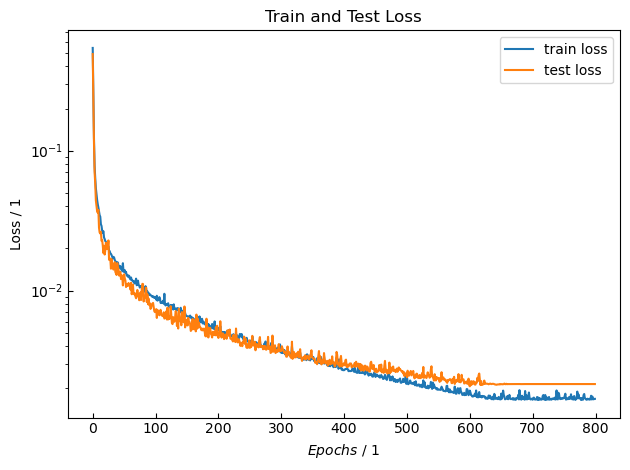

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [10]:
#np.savez('data/models/hyperparams/loss_006_003.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9988952809454348 , R^2(NH3) = 0.9960816187830819
Test Dataset: R^2(H2) = 0.9979505183581753 , R^2(NH3) = 0.9958365714316094
Test R^2 gemittelt:  0.9968935448948923
Max Error Training: |x_H2 - x_H2,pred| = 0.03391408743197988 , |x_NH3 - x_NH3,pred| = 0.05237849274178652
Max Error Test: |x_H2 - x_H2,pred| = 0.03699657456389138 , |x_NH3 - x_NH3,pred| = 0.042240938226670854


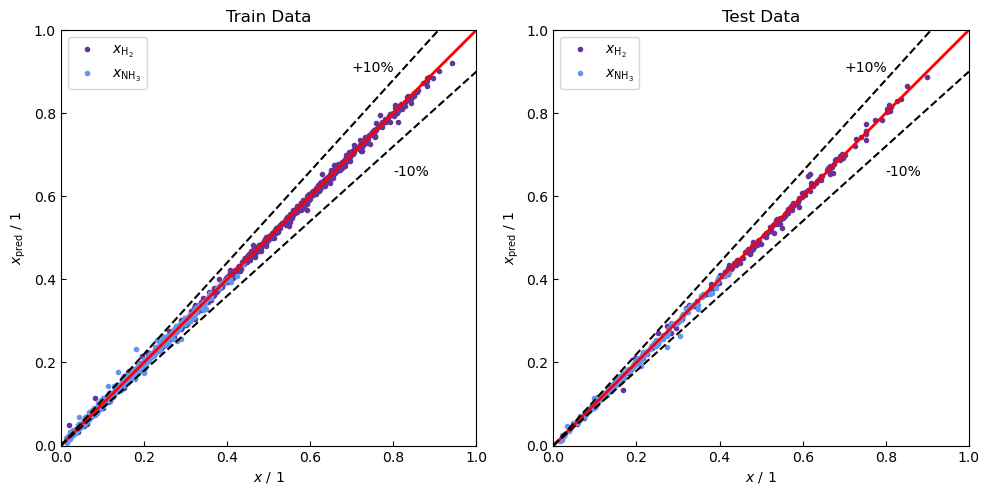

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Test R^2 gemittelt: ', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

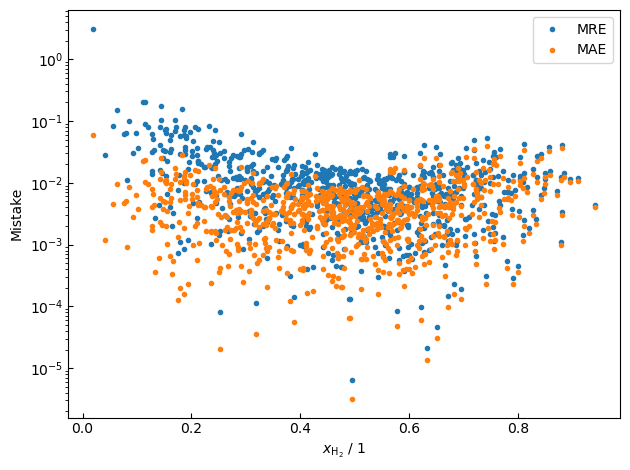

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

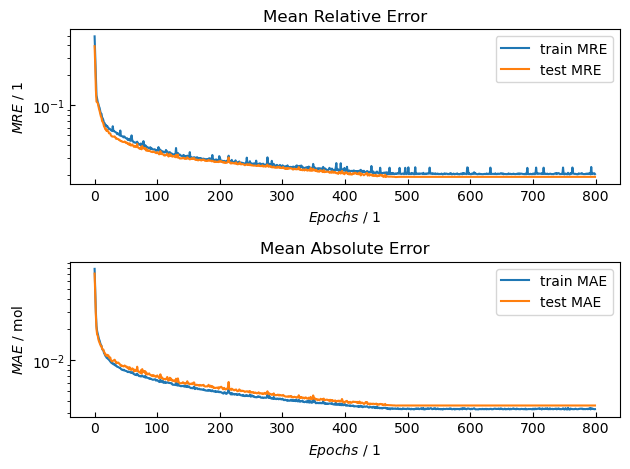

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

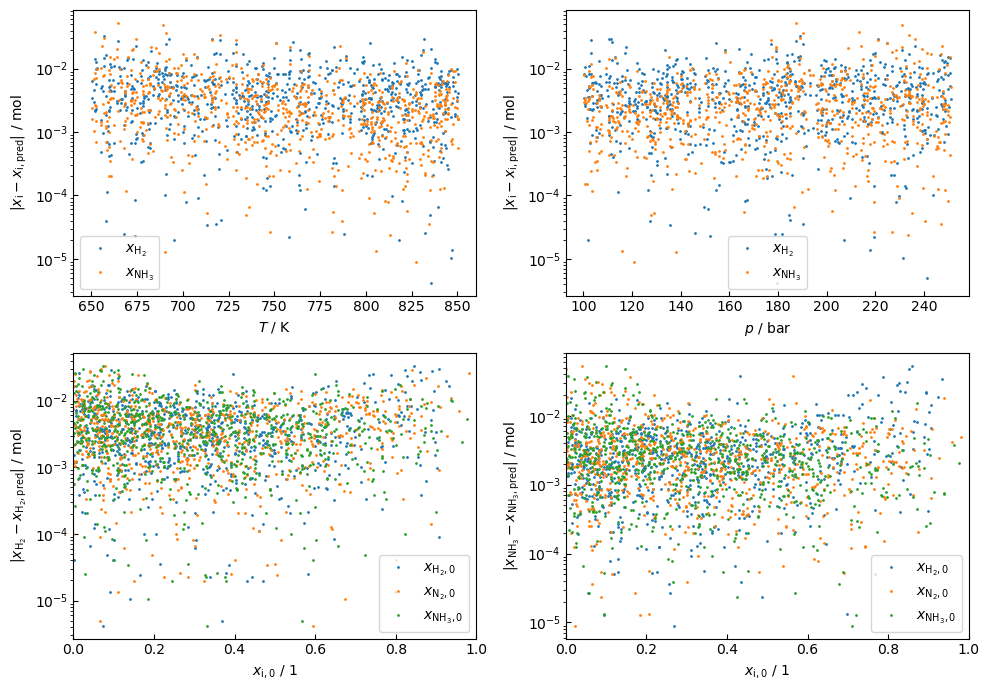

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

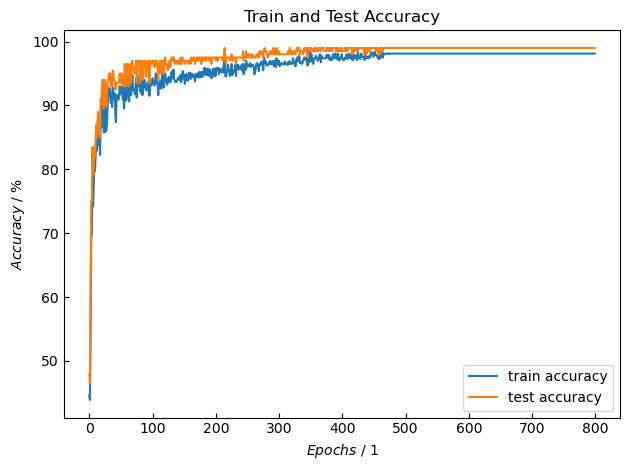

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 7.4539e-01,  1.6291e+00,  1.4267e-01,  1.0845e+00, -1.2484e+00],
        [ 1.3560e+00,  2.0201e-01, -1.0822e+00, -5.7861e-01,  1.6535e+00],
        [ 1.1218e+00, -4.2259e-01,  6.3567e-01, -9.6672e-01,  3.6422e-01],
        [ 6.4162e-01,  9.0515e-02, -4.1377e-01,  2.1817e-01,  1.8308e-01],
        [-3.9412e-01,  9.1316e-01,  4.2615e-01, -4.6728e-01,  5.9380e-02],
        [-1.9498e-01,  1.3053e+00, -2.0781e-01,  1.2658e+00, -1.0898e+00],
        [-1.4826e+00, -1.0141e+00,  1.4888e-02, -1.0017e+00,  1.0092e+00],
        [ 1.9403e-01, -1.4574e+00, -3.0004e-01,  1.5622e+00, -1.3022e+00],
        [ 1.1170e+00,  1.2613e-01,  1.8675e+00, -1.1061e+00, -7.0226e-01],
        [ 9.2303e-01, -1.1778e-01, -1.1215e+00,  9.6405e-01,  1.1525e-01],
        [ 8.7402e-01,  1.3128e+00,  3.0843e-01,  2.2257e-01, -5.3017e-01],
        [-3.3680e-01, -9.1294e-01, -1.0964e+00, -8.5844e-01,  1.9534e+00],
        [ 1.0014e+00,  1.1074e+00,  5.2643e-01,  4.6925e-01, -9.9624e-01],
        [ 9.0258e-01,  1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.8652e-01, -8.6818e-02,  9.8831e-02, -1.9200e-02,  1.5926e-01],
         [-9.5304e-02,  1.6258e-01,  2.7852e-01, -1.1308e-01,  1.5949e-01],
         [-1.5705e-01, -1.0122e-01, -1.1171e-01, -9.3246e-02, -3.4851e-01],
         [ 1.7882e-01, -2.7777e-01, -3.4398e-02, -2.2393e-01,  2.1834e-01],
         [-2.7562e-01, -3.9640e-01,  7.8527e-02,  3.1008e-01,  2.7761e-01],
         [-1.9416e-01,  1.6904e-01,  1.1570e-01,  3.3797e-01,  1.1417e-01],
         [-1.8727e-02,  3.9383e-01, -1.2786e-01, -2.4625e-01, -4.1026e-01],
         [-1.5403e-01,  1.6793e-01,  3.0082e-01, -4.0964e-01, -2.7210e-01],
         [ 6.0671e-02,  1.2385e-01,  7.3360e-02,  1.6873e-01,  4.1814e-01],
         [-1.8195e-01, -2.7474e-01,  1.0367e-01, -3.1379e-01,  2.0521e-01],
         [-3.4305e-01,  3.7585e-01,  3.8237e-01, -2.5525e-01,  3.1925e-01],
         [-2.8677e-01, -6.8130e-03,  2.4978e-01, -1.0872e-01,  8.5208e-02],
         [ 3.4120e-01,  4.3546e-01,  9.2628e-02,  2.4451e-03,  4.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6674, 0.2343, 0.1531, 0.6753, 0.4429],
        [0.0813, 0.3611, 0.2429, 0.5484, 0.3559]])
tensor([[ 0.0355, -0.5539],
        [-0.1099, -0.0157]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.1035,  0.3839,  0.2508, -1.2986,  1.0812],
        [ 0.8195, -1.0486, -0.9871,  0.0787,  0.8883],
        [-0.0237,  1.3288,  0.1479, -1.1712,  1.0520],
        [-0.7409, -0.5610, -1.2218,  2.0842, -0.9312],
        [ 0.5683,  1.5450,  0.6013, -0.8992,  0.3290],
        [ 0.0846, -1.4520, -1.3778,  2.6811, -1.3881],
        [-1.1757, -1.6462,  1.5086, -1.3211, -0.1303],
        [-1.7457,  1.6628, -0.0451,  0.3528, -0.3163],
        [ 1.4755, -1.5753,  2.4516, -1.0261, -1.3571],
        [-0.1934, -1.0697, -1.2763, -1.2917,  2.5728],
        [ 0.8221,  0.0494,  0.8854,  0.3826, -1.2599],
        [ 1.0665,  1.3337, -1.3049, -1.0487,  2.3525],
        [ 0.3287, -0.0761, -1.0797, -0.1199,  1.1822],
        [-1.0682, -1.4838,  2.4750, -1.1018, -1.3028],
        [ 1.4410, -1.2162,  2.4382, -1.2450, -1.1203],
        [-0.2241,  0.3003, -0.6554,  1.7655, -1.1613],
        [-0.1335,  0.9987, -1.2047,  2.2949, -1.1633],
        [ 1.2295, -1.2447, -0.2828, -1.2922,  1.5983],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()